In [2]:
############################## ADRIANA KAMNIK ##############################################
################### NALOGA IZ PODATKOVNEGA RUDARJENJA IN STROJNEGA UĆENJA ##################
######################### ANALIZA ŠKODE NEKE ZAVAROVALNICE #################################


##############################################################################################
##############################################################################################
##################################### VPOGLED PODATKOV ######################################
# Imamo podatke o škodah neke zavarovalnice. To podatkovje vsebuje $10000$ primerov ter $35$ 
# spremenljivk. Verjetno bo potebno za napoved ciljne spremenljivke zreducirati vhodne 
# spremenljvke, da se izognemo prekletstvu večdimenzionalnosti.
# Naloga je preurediti podatke, ter napovedati škodo (= ciljna spremenljivka, Claim_Amount).
library(dplyr)
library(tidyr)
library(caret)
library(ggplot2)
library(rpart)
library(randomForest)
setwd('E://Adriana/Ostalo/Ektimo naloga')
data <- read.table('podatki.csv',sep=',',header=T,na.strings = c('','?')) 
#str(data)
n <- length(data[,1])
data <- select(data,-Row_ID) # Te spremenljivke ni v navodilu.

In [3]:
###########################################################################################
############################### REDUCIRANJE KATEGORIJ ####################################
# Pri spremenljivkah Blind Model, Blind Submodel in Blind Make imamo
# veliko kategorij.
# Če pogledamo v podatkovje vidimo, da so si te spremenljivke zelo podobne,
# kar pove že samo ime. V spremenljivki Blind Submodel so shranjene vse informacije
# od Blind Make in Blind Model. 
# 
# Odločili smo se spremenljivko Blind Submodel razbiti:
#
#  Najprej smo ločili na dva dela: na del s številkami in na del s črkami (= Blind Make)
#  Nato smo pa še Blind Make v dva stolpca, v vsakem stolpcu ena črka.
#
# S tem smo zreducirali število kategorij pri faktorskem vektorju, ter iz številskega dela 
# naredili numerično spremenljivko.
#
# Ocenitev starosti avtomobila
# Ocenili smo približno starost avtomobila:
#
# Ko je bilo avto zavarovano $-$ Model Year,
# 
# kar nam da pa tudi vrednost $-1$.
# To pa zgodi zato: Ko je avto že kupljen in zavarovan, so na avtu spremenili
# nek del avta (npr luČi) in je potem v našem primeru lahko avto eno leto manjše,
# kot je sicer. To je o starosti najboljše kar lahko povemo.

data <- data %>% separate(Blind_Make, into = c('Blind_M1', 'Blind_M2','Blind_M33','Blind_M34'),
                          fill='right',sep='()') %>% select(-Blind_M1,-Blind_M34) %>%
  mutate(Blind_M3 = replace(Blind_M33, Blind_M33 == '', NA)) %>%
  select(-Blind_M33)

data <- data %>%  mutate(Age = Calendar_Year - Model_Year) %>% 
  separate(Blind_Submodel, c('Blind', 'model','submodel'), sep ='[.]') %>% 
  select(-c(Blind,Blind_Model)) %>%
  unite('Submodel',c(model,submodel),sep='.')

tmp_vec <- select(data,Submodel)
tmp_vec <- gsub("NA.NA", '0',tmp_vec[,1]) #NA.NA vrednosti pri Sumbmodelu nadomestimo 0.
data <- data %>% mutate(Submodel.2 = as.numeric(tmp_vec)) %>% select(-Submodel)

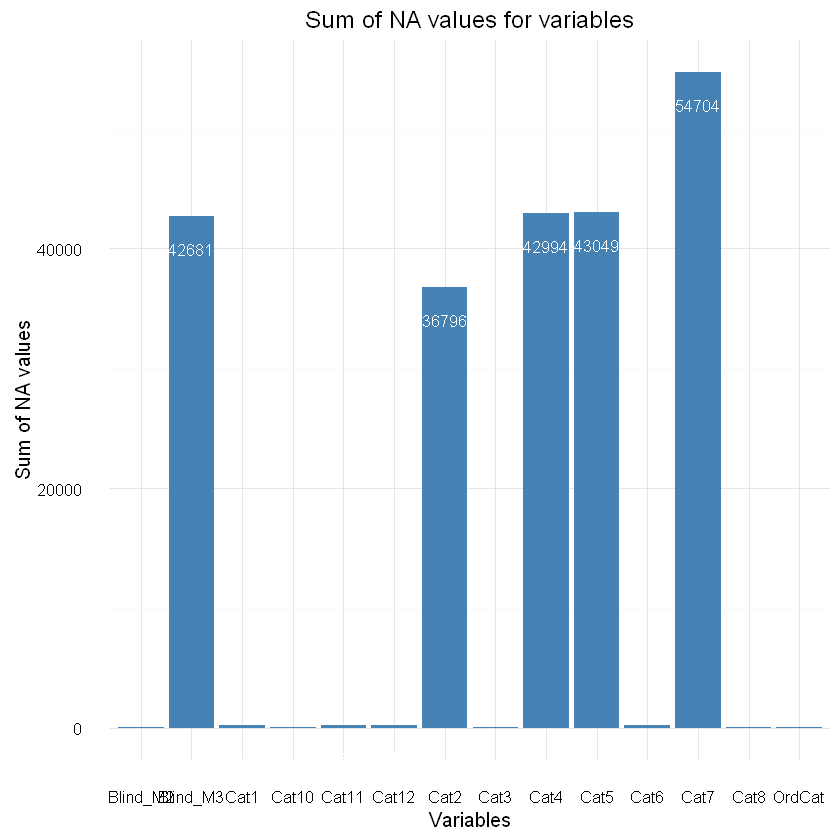

In [4]:
######################################################################################
################################### MANJKAJOČE VREDNOSTI ###################################

# Odstranitev manjkajočih vrednosti ni prava rešitev, ker nam potem ostane približno
# samo 28 % celotnega podatkovja.
data_NA <- data.frame(colSums(is.na(data))) # Tabela, ki pove koliko vrednosti manjka
# pri vsaki spremenljivki
names(data_NA) <- 'Sum_of_NA_v'

ind <- which(data_NA[,1] > 0)
data_NA2 <- data.frame(data_NA[ind,])
row.names(data_NA2) <- row.names(data_NA)[ind]
names(data_NA2) <-'Sum_of_NA_v'
#################################################################### 
ggplot(data=data_NA2, aes(x=row.names(data_NA2), y=Sum_of_NA_v)) +
  geom_bar(stat="identity",fill="steelblue")+
  geom_text(aes(label=Sum_of_NA_v), vjust=3, color="white", size=3.5)+
  labs(title="Sum of NA values for variables", 
       x="Variables", y = "Sum of NA values")+
  theme_minimal()
# Pri spremenljivkah Blind_M3, Cat4, Cat5 manjka skoraj polovica podatkov. Pri Cat7 pa več
# kot polovica podatkov. Po tem lahko sklepamo, da podatki pri teh spremenljivkah ne manjkajo naključno,
# vendar manjkajo nenakljuČno. Vrednosti manjkajo z razlogom in jih je zato težje nadomestiti. 

In [9]:
####################### 1. ODSTRANITEV SPREMENLJIVK #########################

# Vidimo da pri nekaterih spremenljivkah manjka skoraj polovica podatkov.

# KAKO POMEMBNE SO SPREMENLJIVKE ZA NAŠO CILJNO SPREMENLJIVKO?
# Z drevesom, ki sprejme NA vrednosti pogledamo katere spremenljivke so pomembne
# za ciljno spremenljivko.

tree1 <- rpart(data$Claim_Amount~., data = data, control =rpart.control(cp = -1))
varImp(tree1)

# Spremenljivke, pri katerih manjka največ vrednosti so Cat4, Cat5, Cat7 in Blind_M3.
# Z drevesom, ki NA obravnava kot svojo kategorijo smo preverili, da so te spremenljivke
# nepomembne za našo ciljno spremenljivko. 

data <- select(data,-Cat4, -Cat5, -Cat7, -Blind_M3)

,Overall
Age,12.85743983
Blind_M2,7.87559288
Blind_M3,3.82325792
Calendar_Year,5.45385677
Cat1,2.97196133
Cat10,4.12553894
Cat11,8.70936192
Cat12,11.66249893
Cat2,1.19320866
Cat3,1.40823845


In [6]:
################ 2. NADOMESTITEV NA PRI FAKTORSKIH SPREMENLJIVKAH ################

# Definiramo novo kategorijo, kjer manjkajo vrednosti. To naredimo pri spremenljivkah:
# Blind M2, Cat1, Cat2, Cat3, Cat6, Cat8, Cat10, Cat11, Cat12 in NVCat.
mnf <- function(col){ # Funkcija, ki NA vrednost pretvori v kategorijo
  col = factor(as.character(col),exclude=NULL)
}
tmp_data <- data %>%select_if(is.factor) %>% select(-Cat9) # Cat9 je popolna spremen.
data <- data %>% mutate(Blind.M2 = mnf(Blind_M2),
                        Cat1.2 = mnf(Cat1),
                        Cat2.2 = mnf(Cat2),
                        Cat3.2 = mnf(Cat3),
                        Cat6.2 = mnf(Cat6),
                        Cat8.2 = mnf(Cat8),
                        Cat10.2 = mnf(Cat10),
                        Cat11.2 = mnf(Cat11),
                        Cat12.2 = mnf(Cat12),
                        NVCat.2 = mnf(NVCat)) %>%
  select(-Blind_M2,-Cat1,-Cat2,-Cat3,-Cat6,-Cat8,-Cat10,-Cat11,-Cat12,-NVCat)

In [7]:
names(data)

[1] "Household_ID"  "Vehicle"       "Calendar_Year" "Model_Year"   
 [5] "Cat9"          "OrdCat"        "Var1"          "Var2"         
 [9] "Var3"          "Var4"          "Var5"          "Var6"         
[13] "Var7"          "Var8"          "NVVar1"        "NVVar2"       
[17] "NVVar3"        "NVVar4"        "Claim_Amount"  "Age"          
[21] "Submodel.2"    "Blind.M2"      "Cat1.2"        "Cat2.2"       
[25] "Cat3.2"        "Cat6.2"        "Cat8.2"        "Cat10.2"      
[29] "Cat11.2"       "Cat12.2"       "NVCat.2"

In [8]:
################ 3. NADOMESTITEV NA PRI FAKTORSKIH SPREMENLJIVKAH ################
# Taka spremenljivka je OrdCat. Zamenjamo z vrednostjo, ki se največkrat pojavi
# glede na ciljno spremenljivko:

tmp_data <- data  %>% group_by(OrdCat) %>% summarize(numofC = n(), suma = sum(Claim_Amount))
tmp_data

# Odločili smo se manjkajoče vrednosti zamenjati s 6. 
# To pa zato, ker 
#
# je vsota škode pri $6$ enaka $0$ ter od teh,
# ki imajo vsoto škode enako $0$ se $6$ največkrat pojavi.

data <- data %>% replace_na(list(OrdCat = 6))

OrdCat,numofC,suma
1,107,0.0000
2,31445,49765.2694
3,708,121.3771
4,44976,57245.6222
5,22537,21171.9155
6,135,0.0000
7,36,0.0000
NA,56,0.0000


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVVar1,NVVar2,NVVar3,NVVar4
Var1,1,0.5603369,0.7459318,0.5770346,0.9066460,0.7782825,0.6760876,0.2735077,-0.01882558,-0.04367862,-0.01132621,-0.06579855
Var2,0,1.0000000,0.6470781,0.9827025,0.5728292,0.7718901,0.5129109,0.7045626,-0.01764620,-0.05568657,-0.02743253,-0.05586815
Var3,0,0.0000000,1.0000000,0.6577080,0.7863491,0.8278832,0.6713439,0.3621354,-0.03378327,-0.04948243,-0.02068019,-0.07131538
Var4,0,0.0000000,0.0000000,1.0000000,0.5927954,0.7854117,0.5247318,0.6940196,-0.01604255,-0.05631555,-0.02683692,-0.05865954
Var5,0,0.0000000,0.0000000,0.0000000,1.0000000,0.7507860,0.4999762,0.3061252,-0.01884480,-0.04167994,-0.01442260,-0.06456837
Var6,0,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.8047180,0.5819204,-0.03757330,-0.05844595,-0.02456145,-0.07827306
Var7,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.2562481,-0.03384510,-0.05253263,-0.01750965,-0.07015890
Var8,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,-0.03525240,-0.04340779,-0.03436117,-0.05070921
NVVar1,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.00000000,-0.01124870,-0.03988390,0.07327420
NVVar2,0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,1.00000000,0.01932431,-0.04734705


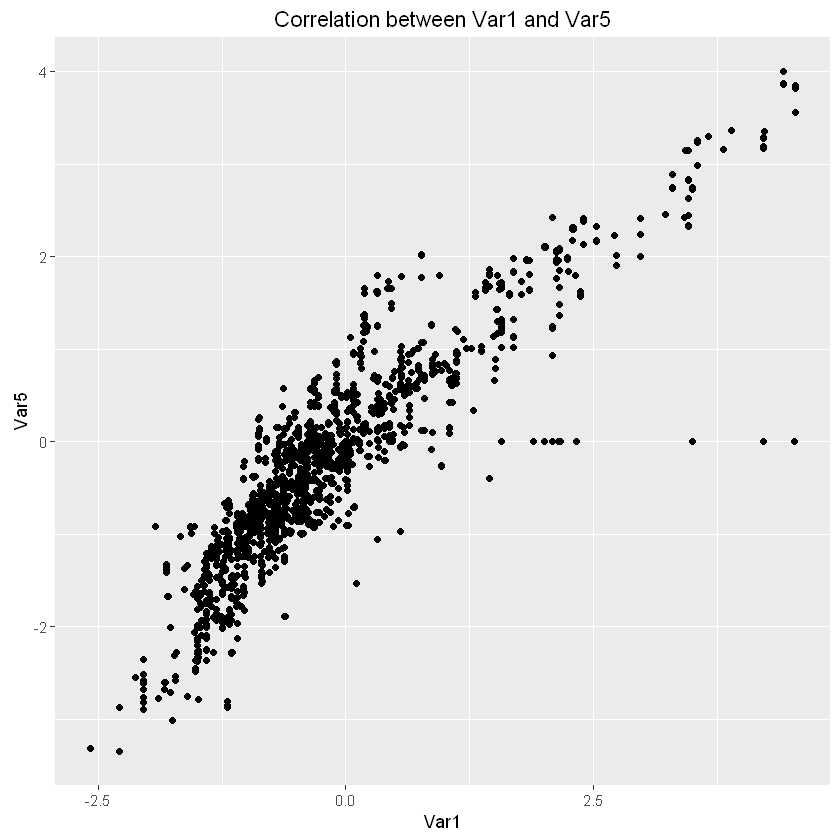

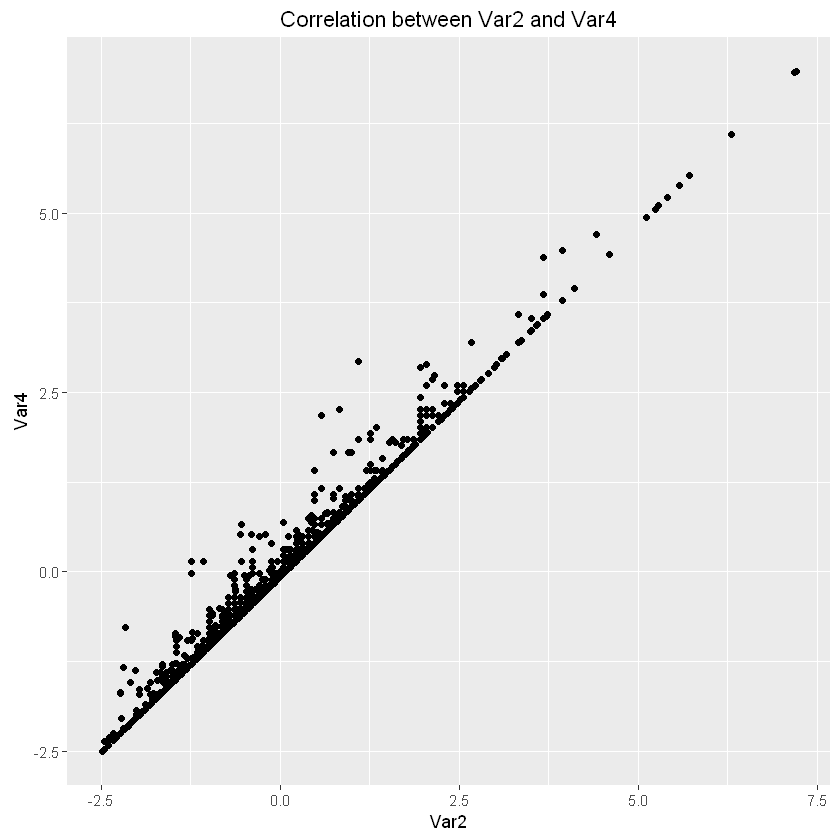

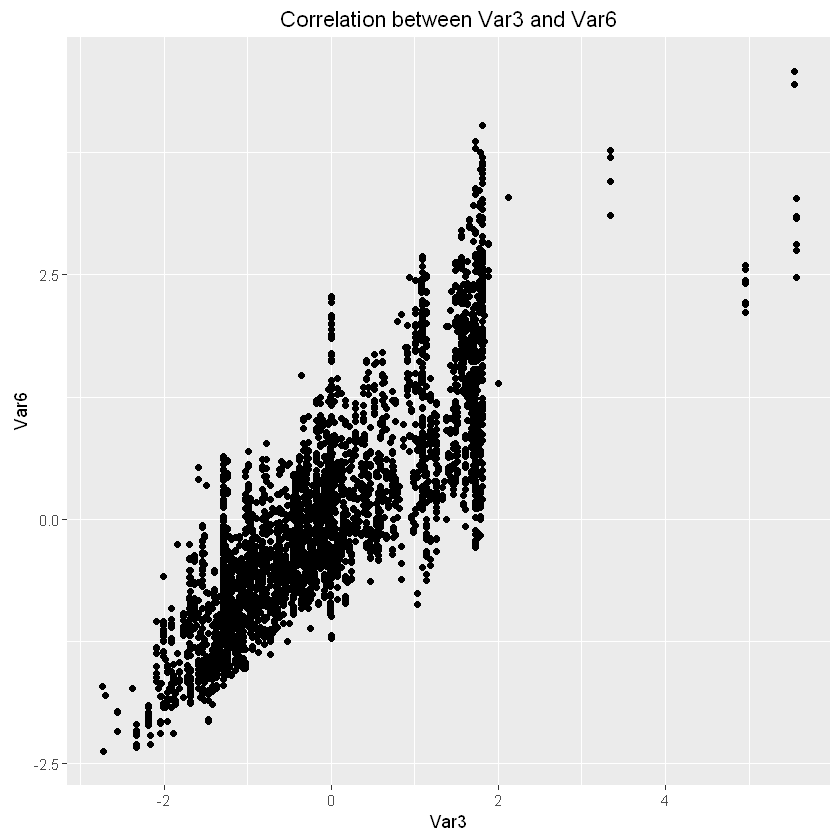

In [18]:
##############################################################################################
################################ KORELACIJA MED SPREMENLJIVKAMI ###############################

# Videti je nekakšna korelacija med spremenlivkami Var1-Var8 in VarNV1-VarNV4.
tmp_data1 <- select(data, Var1:Var8)
tmp_data2 <- select(data,   NVVar1:NVVar4)
tmp_data <- cbind(tmp_data1,tmp_data2)

corel <- cor(as.matrix(tmp_data))
corel[lower.tri(corel)] <- 0
corel
ggplot(tmp_data, aes(Var1, Var5)) + geom_point() + labs(title='Correlation between Var1 and Var5')
ggplot(tmp_data, aes(Var2, Var4)) + geom_point() + labs(title='Correlation between Var2 and Var4')
ggplot(tmp_data, aes(Var3, Var6)) + geom_point() + labs(title='Correlation between Var3 and Var6')

# Med Var2 in Var4 je visoka pozitivna korelacija. 
# V ostalih dveh primerih je tudi pozitivna, vendar ne tako visoka. Korelacija me spremenljivko
# Var2 in Var4 je skoraj enaka 1.

In [19]:
################################################################################
##################### GRUPIRANJE PODATKOV GLEDE NA ZAVAROVANO LETO ############

myggplot <- function(mydata,color,main_title,xlab,ylab){
  xaes <- names(mydata)[1]
  yaes <- names(mydata)[2]
  ggplot(data=mydata, aes_string(x=xaes, y=yaes)) +
    geom_bar(stat="identity",fill=color)+
    geom_text(aes(label= round(mydata[,2],digits = 2)), vjust=1.6, color="white", size=3.5)+
    labs(title=main_title,
         x= xlab, y = ylab)+
    theme_minimal()
} 

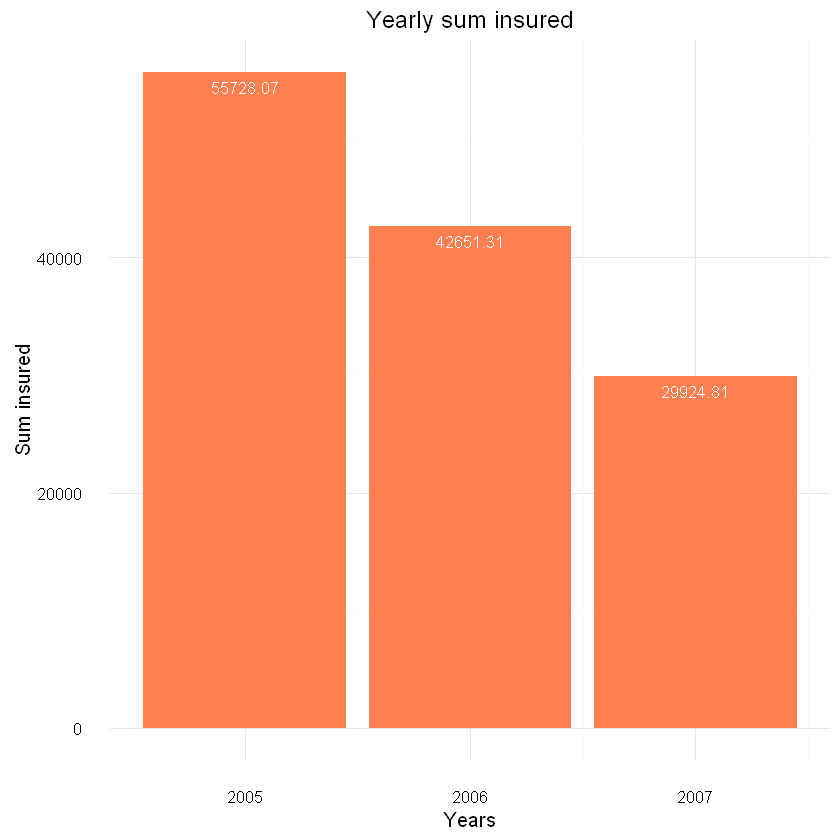

In [20]:
Sum_of_CalendarYear <- data %>% group_by(Calendar_Year) %>% summarise(sum(Claim_Amount))
# rename(dsfgdg =names(Sum_of_CalendarYear)[2])
names(Sum_of_CalendarYear)[2] <- 'Sum_of_CA'

myggplot(as.data.frame(Sum_of_CalendarYear),'coral',
         "Yearly sum insured",'Years','Sum insured')

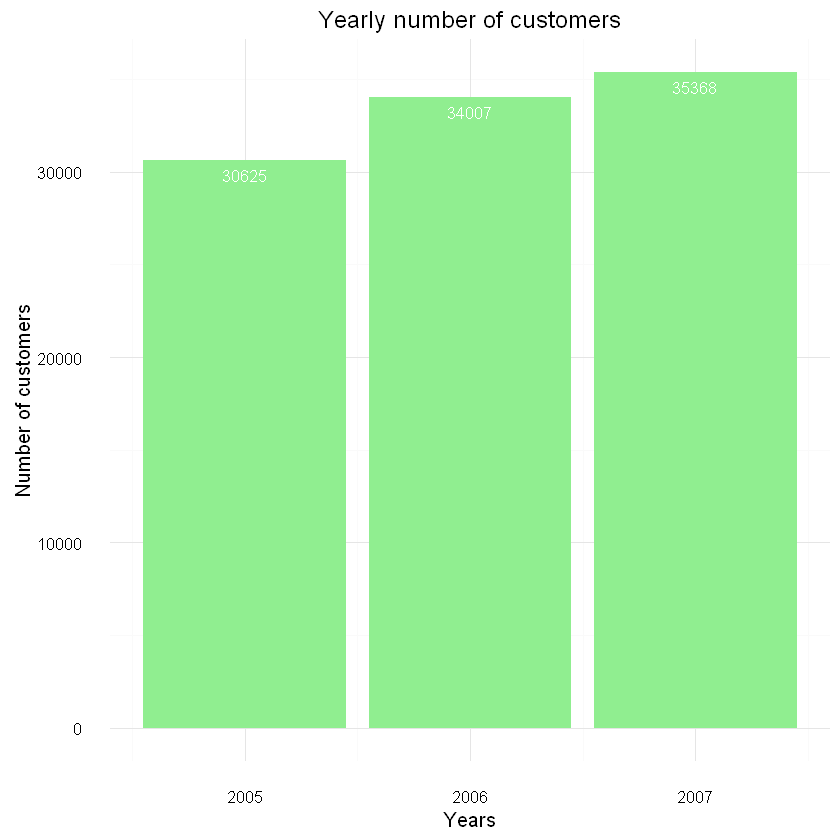

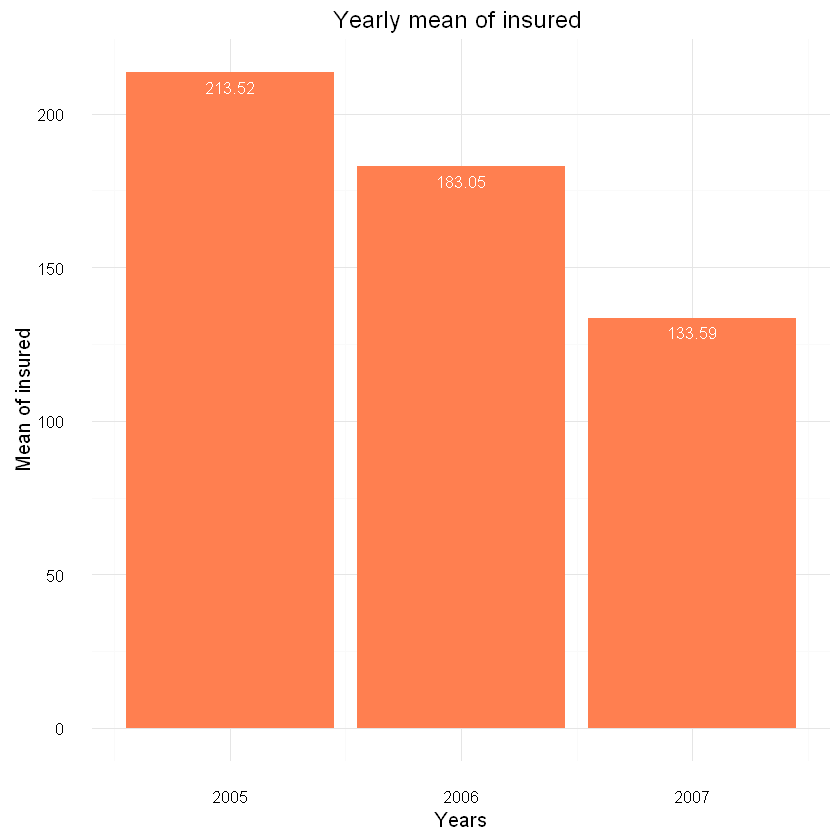

In [21]:
# Ali zavarovalnica z leti posluje boljše?
# Z leti se škoda zniža. Vendar to ne pomeni nujno, da zavarovalnica boljše posluje.
# Smiselno je tudi pogledati, koliko je bilo sklenjenih zavarovanj ter kolikšna je bila
# povprečna škoda na leto.

Number_of_CalendarYear <- data %>% group_by(Calendar_Year) %>% summarise(length(Calendar_Year))
names(Number_of_CalendarYear)[2] <- 'Number_of_customer'
myggplot(as.data.frame(Number_of_CalendarYear),'lightgreen',
         "Yearly number of customers",'Years','Number of customers')

Mean_of_insured <- data %>% group_by(Calendar_Year) %>% filter(Claim_Amount !=0) %>%
  summarise(mean(Claim_Amount))
names(Mean_of_insured)[2] <- 'Mean_of_ins'
myggplot(as.data.frame(Mean_of_insured),'coral',
         'Yearly mean of insured ','Years','Mean of insured')

In [22]:
##############################################################################################
##############################################################################################
########################### NAPOVED CILJNE SPREMENLJIVKE ######################################
# Za napovedovanje ciljne spremenljivke vzamemo samo spremenljivke, katere je drevo določilo,
# da so pomembne. 
tree2 <- rpart(data$Claim_Amount~., data = data, control =rpart.control(cp = -1))
varImp(tree2)

,Overall
Age,9.6398397
Blind.M2,6.9000736
Calendar_Year,3.9304900
Cat1.2,4.6430597
Cat10.2,4.8329268
Cat11.2,8.6845945
Cat12.2,12.7098546
Cat2.2,2.8084233
Cat3.2,0.7339763
Cat6.2,1.5786774


In [35]:
# Najprej razdelimo množico na učno in testno. Za merjenje napake smo izbrali zanjkanje oziroma vzorčenje.
# t <-createDataPartition(data$Claim_Amount, p=0.6, list=FALSE)
# trainData <- data[t,]
# testData <-  data[-t,]
# trainCtrl <- trainControl(method='boot', number=10, savePredictions=TRUE)
# m1 <- train(Claim_Amount ~ Household_ID + Var8 + Cat12.2 + Var6 +
#            + NVCat.2 + Submodel.2 + Age, data= trainData, method='rf',
#            trControl=trainCtrl, importance=T)
# m1$results
# varImp(m1$results)
#mtry	RMSE	Rsquared	RMSESD	RsquaredSD
#2 	34.01921 	1.509521e-05	6.133932 	1.958674e-05
#13 	36.07324 	6.640942e-06	5.357734 	1.219832e-05
#25 	38.08182 	7.577561e-06	4.822173 	1.397781e-05

In [64]:
m1$results

mtry,RMSE,Rsquared,RMSESD,RsquaredSD
2,34.01921,1.509521e-05,6.133932,1.958674e-05
13,36.07324,6.640942e-06,5.357734,1.219832e-05
25,38.08182,7.577561e-06,4.822173,1.397781e-05


In [1]:
#################### ROC KRIVULJA IN AUC PLOŠČINA ################################
#roc1 <- roc(testData$Claim_Amount, predict(m1, testData))
#auc1 <- roc1$auc # 0.6427
#plot(roc1, col='red')

ERROR: Error in eval(expr, envir, enclos): could not find function "roc"


In [3]:
# roc krivulja in ploščina auc pod kiruvljo.

In [29]:
options("scipen"=100, "digits"=4)
t2 <-createDataPartition(data$Claim_Amount, p=0.6, list=FALSE)
trainData2 <- data[t2,]
testData2 <-  data[-t2,]
trainCtrl2 <- trainControl(method='boot', number=10, savePredictions=TRUE)
m2 <- train(Claim_Amount ~ Household_ID + Var8 + Cat12.2 + Var6 +
            + NVCat.2 + Submodel.2 + Age + Cat11.2 + Model_Year + Var2 + Var5, data= trainData2, method='rf',
            trControl=trainCtrl2)
m2$results


mtry,RMSE,Rsquared,RMSESD,RsquaredSD
2,37.52133,0.0001036445,7.855855,7.471592e-05
18,41.06269,0.0002410016,6.575196,3.812482e-04
34,43.92799,0.0002144205,6.097555,4.018337e-04


In [67]:
library(pROC)



Call:
roc.default(response = testData2$Claim_Amount, predictor = predict(m2,     testData2))

Data: predict(m2, testData2) in 39705 controls (testData2$Claim_Amount 0) < 1 cases (testData2$Claim_Amount 0.04000914).
Area under the curve: 0.9496

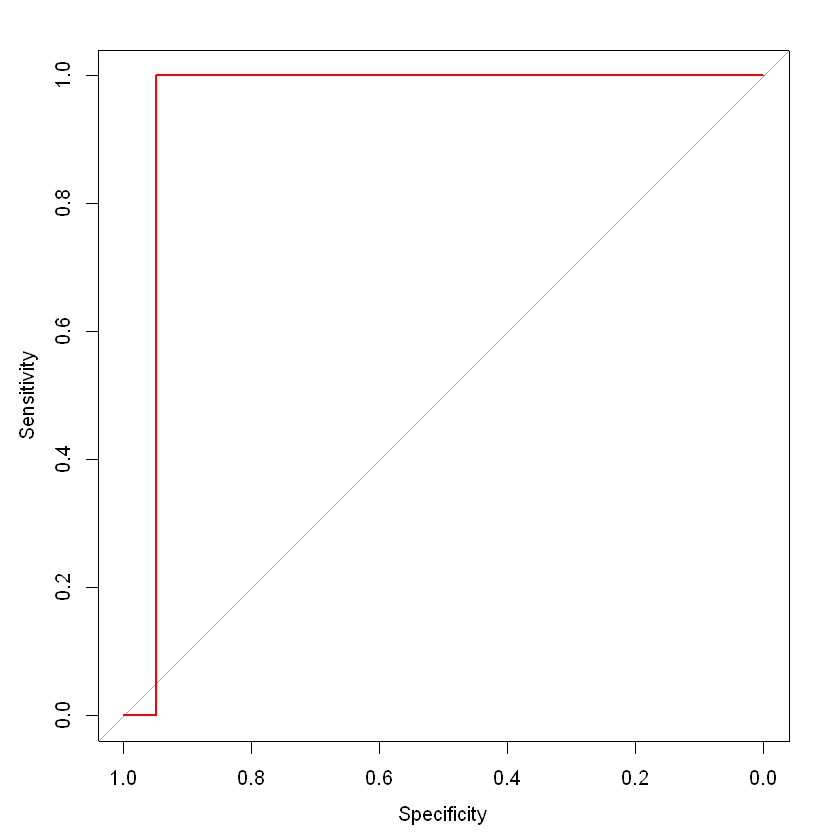

In [33]:
roc2 <- roc(testData2$Claim_Amount, predict(m2, testData2))
auc2 <- roc2$auc # 0.6427
plot(roc2, col='red')

In [38]:
png("image.png", width = 800, height = 600)
plot(roc2, col='red')
dev.off()


Call:
roc.default(response = testData2$Claim_Amount, predictor = predict(m2,     testData2))

Data: predict(m2, testData2) in 39705 controls (testData2$Claim_Amount 0) < 1 cases (testData2$Claim_Amount 0.04000914).
Area under the curve: 0.9496

png 
  2

mtry,RMSE,Rsquared,RMSESD,RsquaredSD
2,37.52133,0.0001036445,7.855855,7.471592e-05
18,41.06269,0.0002410016,6.575196,3.812482e-04
34,43.92799,0.0002144205,6.097555,4.018337e-04


In [55]:
auc(testData2$Claim_Amount,  predict(m2, testData2))

Area under the curve: 0.9496

In [68]:
## Interpretacija AUC ploščine:
a <- which(testData2$Claim_Amount !=0)

In [69]:
length(a)

[1] 295

In [70]:
head(a)

[1]  38 178 584 586 631 657

In [71]:
p <- predict(m2, testData2)

In [72]:
pp <- p[a]

In [73]:
head(pp)

81       457      1506      1509      1630      1685 
1.4613668 1.8835031 0.6934931 0.6193720 1.4369688 0.7207402

In [74]:
head(testData2$Claim_Amount[a])

[1] 582.007900 908.513500  43.197150  26.006840   5.739397   3.047405

In [76]:
dd <- data.frame(testData2$Claim_Amount[a],pp)
write.csv(dd,'dd.csv')

In [77]:
pp2 <- data.frame(testData2$Claim_Amount,p)
write.csv(pp2,'pp2.csv')

In [79]:
head(p,15)

2         5         6         8         9        10        14        15 
0.9406560 0.8660664 0.3050824 0.7255393 0.5056322 0.8917696 0.4929621 2.4872385 
       17        20        22        23        24        25        28 
0.4371677 4.8954408 0.6991391 0.7485738 0.5067827 1.1640742 1.1090908

In [ ]:
m3 <- train(Claim_Amount ~ Household_ID + Var8 + Cat12.2 + Var6 +
            + NVCat.2 + Submodel.2 + Age + Cat11.2 + Model_Year + Var2 + Var5, data= trainData2, method='rf',
            trControl=trainCtrl2)
m3$results

In [5]:
m2$results

ERROR: Error in eval(expr, envir, enclos): object 'm2' not found
